<a href="https://colab.research.google.com/github/Surojit-KB/UNIV-AI-AI3_Project/blob/main/Baseline_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AI-3 PROJECT: TEACHING ASSISTANT BOT
Project implemented by:
1. Olga Graf
2. Arjun Beniwal
3. Harsh Goyal
4. Surojit Bhattacharyya
5. Sukriti Paul

**Link to Video:**<br>
https://drive.google.com/file/d/1RKqj_s4siYmYjKgCeBF-eyCJroWzMAtB/view?usp=sharing


## 1. INTRODUCTION
### 1.1 Motivation
Chatbots are one of the most popular applications of Natural Language Processing. For the scope of this project, we will focus on creating a user-friendly tool that helps the Teaching Staff automatically answer questions posed by students on a forum.

The core problem we are trying to solve is to help answer questions that are frequently asked by students in a learning setup. We are not looking for a bot that is capable of answering extremely specific and one-of-a-kind questions. The idea is to reduce the load from the TAs but dealing with questions that are repetitive and whose response does not change in different scenarios.

### 1.2 The Dataset

We are using the **S**tanford **Q**uestion **A**nswering **D**ataset (SQuAD) for this project. It is a new reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage. With 100,000+ question-answer pairs on 500+ articles, SQuAD is significantly larger than previous reading comprehension datasets. SQuAD 1.1, the previous version of the SQuAD dataset, contains 100,000+ question-answer pairs on 500+ articles. SQuAD2.0 combines the 100,000 questions in SQuAD1.1 with over 50,000 unanswerable questions written adversarially by crowdworkers to look similar to answerable ones. To do well on SQuAD2.0, systems must not only answer questions when possible, but also determine when no answer is supported by the paragraph and abstain from answering.<br>
For this project, we haven't used the unanswered question from the SQUAD dataset because we already have the test set from UNIV.ai faqs data and test data for testing our model. Since the context of the SQUAD dataset is quite different and we don't have context in the faq dataset provided in the challenge, we have also manually scraped context data from the UNIV.ai courses page and Edstem forum to provide more context related to the test data. You can find the dataset in the `context.csv` file provided with the notebook.<br>

### 1.3 The Models
**We have 2 different notebooks for implementing the baseline and the advanced models because we wanted to keep the codes organized and separated.** The Baseline model consists of a basic Language model trained on the context data from the SQUAD dataset. The embeddings trained on the context data is then extracted and provided as an input to a SEQ2SEQ (S2S) model. The S2S model takes the questions as input from the encoder and provides answers as output from the decoder. This model is not fine-tuned on the context data since its a baseline and we want to see how a naive model works on the test data.<br>
For the advanced model, we have used pretrained ALBERT architechture from the HuggingFace library. Its a Transformer model, which requires context as input and provides us the part of the context that can work as the answer. Since we dont always have context for the questions, we tried to overcome this problem by using a cross-encoder architechture which worked quite well on the test data but requires a bit more time to train. We also tried a T5 model but the limited data meant that we couldn't get a good result from this model. Further details is provided in the respective notrbooks.<br>

On this note, lets get started with the Baseline model.<br>

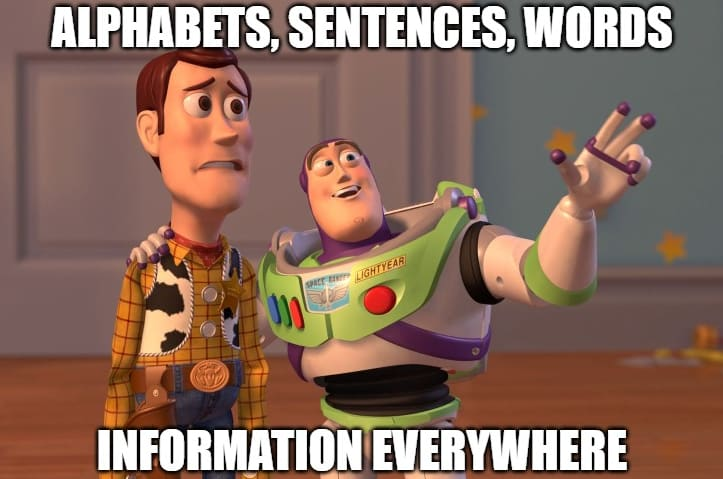


In [ ]:
#IMPORTING THE NECESSARY LIBRARIES
import re
import os
import json
import zipfile
import collections
import numpy as np
import pandas as pd
import urllib.request
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed,LSTM, GRU,Dropout, Bidirectional, Conv1D, BatchNormalization
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.layers import Flatten
from sklearn.model_selection import train_test_split
from collections import Counter
from operator import itemgetter
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
#INSTALLING THE SENTENCEPIECE LIBRARY FOR SENTENCEPIECE TOKENIZER
!pip install sentencepiece
import sentencepiece as spm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Getting the data and preprocessing
The SQUAD dataset is in the form of a JSON file, hence we need to load it manually into a dataframe. This part of the notebook focuses on loading the dataframe, preprocessing the data and getting the context text ready for tokenization.

In [ ]:
#THIS IS THE CODE TO PREPROCESS THE SQUAD DATASET AND CREATE A DATAFRAME OUT OF IT
def get_dataframe(file):
  f = open(file, 'r')
  #loading json file 
  data = json.loads(f.read())
  #creating empty lists to store df values 
  iid = []
  tit = []
  con = []
  que = []
  ans = []
  txt = []
  #root tags contains 'title' tag and 'paragraphs' list 
  for i in range(len(data['data'])):
    title = data['data'][i]['title']
    #'paragraphs' list contains 'context' tag and 'qas' list 
    for p in range(len(data['data'][i]['paragraphs'])):
      context = data['data'][i]['paragraphs'][p]['context']
      for q in range(len(data['data'][i]['paragraphs'][p]['qas'])):
        # 'qas'list contains 'question', 'Id' tag and 'answers' list 
        question = data['data'][i]['paragraphs'][p]['qas'][q]['question']
        id = data['data'][i]['paragraphs'][p]['qas'][q]['id']
        #'answers' list contains 'answer_start' and 'text' tag 
        for a in range(len(data['data'][i]['paragraphs'][p]['qas'][q]['answers'])):
          ans_start = data['data'][i]['paragraphs'][p]['qas'][q]['answers'][a]['answer_start']
          text = data['data'][i]['paragraphs'][p]['qas'][q]['answers'][a]['text']
          
          #appending values to list 
          iid.append(id)
          tit.append(title)
          con.append(context)
          que.append(question)
          ans.append(ans_start)
          txt.append(text)
  #creating dataframe from lists 
  new_df = pd.DataFrame(columns=['Id', 'title', 'context', 'question', 'ans_start', 'text'])
  new_df.Id = iid
  new_df.title=tit
  new_df.context = con
  new_df.question = que
  new_df.ans_start = ans 
  new_df.text = txt 
  #removing duplicate columns 
  final_df = new_df.drop_duplicates(keep='first')

  return final_df

In [ ]:
#GETTING THE DATAFRAME READY
df=get_dataframe('/content/drive/MyDrive/Colab Notebooks/UNIV-AI-AI3/train-v2.0.json')

In [ ]:
#DISPLAY THE DATAFRAME
df.head(10)

,Id,title,context,question,ans_start,text
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,269,in the late 1990s
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,207,singing and dancing
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,526,2003
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,166,"Houston, Texas"
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,276,late 1990s
5,56bf6b0f3aeaaa14008c9603,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what R&B group was she the lead singer?,320,Destiny's Child
6,56bf6b0f3aeaaa14008c9604,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What album made her a worldwide known artist?,505,Dangerously in Love
7,56bf6b0f3aeaaa14008c9605,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,Who managed the Destiny's Child group?,360,Mathew Knowles
8,56d43c5f2ccc5a1400d830a9,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyoncé rise to fame?,276,late 1990s
9,56d43c5f2ccc5a1400d830aa,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What role did Beyoncé have in Destiny's Child?,290,lead singer


In [ ]:
#INFO ABOUT THE DATASET
print('The number of different titles in the SQUAD dataset are:',df.title.nunique())
print('The number of different context paragraphs in the SQUAD dataset are:',df.context.nunique())
print('The number of unique question-answer pairs in the SQUAD dataset are:',df.question.nunique())

The number of different titles in the SQUAD dataset are: 440
The number of different context paragraphs in the SQUAD dataset are: 18877
The number of unique question-answer pairs in the SQUAD dataset are: 86769


In [ ]:
#NEXT WE WILL CREATE A TEXT STRING OUT OF ALL THE UNIQUE CONTEXT PARAGRAPHS WE HAVE
#THIS TEXT WILL BE USED TO TRAIN A SIMPLE BASELINE MODEL
text=''.join(df.context.unique())

In [ ]:
#SINCE THE DATA CONTAINS A LOT OF PHONETIC CHARACTERS, WE WILL CONVERT THEM TO NORMAL CHARACTERS FOR SAKE OF BETTER ENCODING
#THIS WILL HELP US IN BETTER TOKENIZATION
import unicodedata
normalized_text=str(unicodedata.normalize('NFD', text).encode('ascii', 'ignore'))
#FURTHER CLEANING TO REMOVE THE SPECIAL CHARACTERS AND LOWERCASE THE TEXT
cleaned_text=re.sub('[^A-Za-z0-9.\' ]+','',normalized_text[2:])
cleaned_text=cleaned_text.lower()

In [ ]:
#TO CONVERT THE TEXT INTO SENTENCES, WE ARE USING A TOKENIZER FROM THE NLTK LIBRARY.
#THE TEXT THAT WE HAVE HAS QUITE MANY PERIODS WHICH DO NOT ALWAYS DENOTE THE END OF A SENTENCE
#NLTK TOKENIZER IS BEST SUITED FOR THIS PURPOSE
import nltk.data
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
list_of_sentence=tokenizer.tokenize(cleaned_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#EXAMPLE OUTPUT OF THE TOKENIZER FOR CREATING A LIST OF SENTENCE
list_of_sentence[:10]

['beyonce giselle knowlescarter bijnse beeyonsay born september 4 1981 is an american singer songwriter record producer and actress.',
 "born and raised in houston texas she performed in various singing and dancing competitions as a child and rose to fame in the late 1990s as lead singer of rb girlgroup destiny's child.",
 "managed by her father mathew knowles the group became one of the world's bestselling girl groups of all time.",
 "their hiatus saw the release of beyonce's debut album dangerously in love 2003 which established her as a solo artist worldwide earned five grammy awards and featured the billboard hot 100 numberone singles crazy in love and baby boy.following the disbandment of destiny's child in june 2005 she released her second solo album b'day 2006 which contained hits deja vu irreplaceable and beautiful liar.",
 'beyonce also ventured into acting with a golden globenominated performance in dreamgirls 2006 and starring roles in the pink panther 2006 and obsessed 2009

## 3. TOKENIZATION
Next we will tokenize the context data using the SentencePiece Tokenizer. 

SentencePiece is an unsupervised text tokenizer and detokenizer mainly for Neural Network-based text generation systems where the vocabulary size is predetermined prior to the neural model training. SentencePiece implements subword units (e.g., byte-pair-encoding (BPE) [Sennrich et al.]) and unigram language model [Kudo.]) with the extension of direct training from raw sentences. SentencePiece allows us to make a purely end-to-end system that does not depend on language-specific pre/postprocessing. More info can be found [here](https://github.com/google/sentencepiece).

We will use a tokenizer with byte-pair-encoding.
The general idea of byte-pair-encoding is to do the following ([source](https://towardsdatascience.com/sentencepiece-tokenizer-demystified-d0a3aac19b15)):

1. Go through your corpus and find all the “bytes” i.e. the irreducible characters from which all others can be built. This is our base. It ensures we can almost always reconstruct any unseen input.
2. Run a sliding window over the entire corpus (the actual code is slightly different) and find the most frequent bigram. Bigrams are formed from consecutive subwords in the current list of seen subwords. So, “hello” would have the counts {“he”: 1, “el”:1, “ll”:1, “lo”: 1}.
3. Choose the most frequent bigram, add it to the list of subwords, then merge all instances of this bigram in the corpus.
4. Repeat until you reach your desired vocabulary size.

The vocabulary size is fixed at 6000 for the complete baseline modelling.

In [ ]:
#WE WILL SAVE ALL THE SENTENCES IN A TEXT FILE, WHICH WILL BE PROVIDED THE TOKENIZER TO WORK ON
rect_path='./context.txt'
with open(rect_path, 'w', errors = 'ignore') as file:
    for line in list_of_sentence:
      file.write(line+'\n')

In [ ]:
#DEFINING THE TOKENIZER
def sentencepiece_():
  templates= '--input={} \
  --pad_id={} \
  --bos_id={} \
  --eos_id={} \
  --unk_id={} \
  --model_prefix={} \
  --vocab_size={} \
  --character_coverage={} \
  --model_type={}'

  train_input_file = rect_path
  prefix = './en_spm' 
  pad_id=0  #PAD ID
  vocab_size = 6000 
  bos_id=1  #BEGIN OF SENTENCE ID
  eos_id=2  #END OF SENTENCE ID
  unk_id=3  #UNKNOWN ID
  character_coverage = 1.0 
  model_type ='bpe' 


  cmd = templates.format(train_input_file,
                pad_id,
                bos_id,
                eos_id,
                unk_id,
                prefix,
                vocab_size,
                character_coverage,
                model_type)
 
  spm.SentencePieceTrainer.train(cmd) #TRAINING THE TOKENIZER

  sp = spm.SentencePieceProcessor()
  sp.load('./en_spm.model')
  return sp

In [ ]:
sp=sentencepiece_() #TRAINED TOKENIZER

In [ ]:
#NEXT WE GET THE VOCABULARY OUT OF THE TOKENIZER MODEL
#WE WILL CREATE A WORD TO INDEX AND INDEX TO WORD DICTIONARY FOR FURTHER USE
def dictionary():
  with open('./en_spm.vocab', encoding='utf-8') as f:
      Vo = [doc.strip().split("\t") for doc in f]

  # w[0]: token name    
  # w[1]: token score 
  word2idx_en = {w[0]: i for i, w in enumerate(Vo)}
  idx2word_en = {i:w[0] for i, w in enumerate(Vo)}

  return word2idx_en, idx2word_en
word2idx,idx2word=dictionary()

In [ ]:
#NOW, WE CREATE FUNCTIONS FOR ENCODING THE INPUT TEXT AND CONVERTING THEM TO SEQUENCES
#ENCODING WILL SEPARATE THE WORDS IN THE TEXT INTO SUB-WORDS AS PER THE TOKENIZER VOCAB
#THEN WE WILL ENCODE THESE SUB-WORDS INTO TOKENS BASED ON VOCAB
def encode_data(input):
            pieces = sp.encode_as_pieces(input)
            return pieces
def texts_to_sequences(texts):
        sequences = []
        for text in texts:
            text_list = text.split()
            sequence = [int(word2idx.get(token, word2idx["<unk>"])) for token in text_list]
            sequences += sequence
        return sequences

In [ ]:
#HERE WE CREATE THE TOKEN LIST FOR ALL THE SENTENCES WE HAVE
token_list=[]
for i in list_of_sentence:
  encoded_data=encode_data(i)
  tokens=texts_to_sequences(encoded_data)
  tokens.append(2) #ADDING THE END TOKEN TO THE TOKEN-LIST
  tokens=[1]+tokens #ADDING THE START TOKEN TO THE TOKEN-LIST
  token_list.append(tokens)

In [ ]:
print('The MIN sequence length of the input data is:',np.min([len(i) for i in token_list]))
print('The MAX sequence length of the input data is:',np.max([len(i) for i in token_list]))
print('The mean sequence length of the input data is:',np.mean([len(i) for i in token_list]))

The MIN sequence length of the input data is: 3
The MAX sequence length of the input data is: 738
The mean sequence length of the input data is: 48.01034322009207


In [ ]:
#TO MAKE SURE WE HAVE SUFFICIENT DATA FOR TRAINING WITHOUT HAVING TOO MUCH PADDED SEQUENCES,
#THE MINIMUM SEQUENCE LENTGH WAS CONSIDERED TO BE 20 AND THE MAX SEQUENCE LENGTH WAS CONSIDERED TO BE 250
cleaned_list=[]
for i in token_list:
  if len(i)>20:
    if len(i)>250:
      cleaned_list.append(i[:250]+[2])
    else:
      cleaned_list.append(i)
maxlen=len(max(cleaned_list,key=len))

In [ ]:
print('The maximum sequence length of the input data is:',maxlen)

The maximum sequence length of the input data is: 251


In [ ]:
#LETS SEE WHAT AN INPUT SENTENCE LOOKS LIKE IN TERMS OF THE ENCODING
print([idx2word[i] for i in token_list[8]])

['<s>', '▁throughout', '▁a', '▁career', '▁sp', 'an', 'ning', '▁19', '▁years', '▁she', '▁has', '▁sold', '▁over', '▁11', '8', '▁million', '▁records', '▁as', '▁a', '▁sol', 'o', '▁artist', '▁and', '▁a', '▁further', '▁60', '▁million', '▁with', '▁dest', 'iny', "'", 's', '▁child', '▁making', '▁her', '▁one', '▁of', '▁the', '▁best', 'se', 'lling', '▁music', '▁artists', '▁of', '▁all', '▁time', '.', '</s>']


## 4. BASELINE LANGUAGE MODEL
Now we will creata a baseline language model which will be trained on the context data and provide us with the embeddings for the vocabulary. It is a very basic Sequential model consisting of:
1. An Embedding Layer of dimension 300
2. An LSTM layer of dimension 512
3. An Dropout Layer with dropout rate of 0.2
4. A second LSTM layer of dimension 512
5. A second Dropout Layer with dropout rate of 0.2
6. A Dense layer of vocab size with softmax activation

The batch size of the dataset is 128, the model was trained for around 40 epochs in 4 rounds (since it took a long time to train the epochs, the model was trained for 10 epochs in each round and the weights were saved after each round).

In [ ]:
#Function for creating the dataset
def get_dataset(token_list):
  inp_token=[i[:-1] for i in token_list]
  target_token=[i[1:] for i in token_list]
  ragged_inp=tf.ragged.constant(inp_token)
  ragged_target=tf.ragged.constant(target_token)
  dataset = tf.data.Dataset.from_tensor_slices((ragged_inp,ragged_target))
  dataset = dataset.batch(128)
  dataset = dataset.map(lambda x,y: (x.to_tensor(default_value=0, shape=[None, None]), y.to_tensor(default_value=0, shape=[None, None])), num_parallel_calls=5)
  dataset = dataset.prefetch(1)
  return dataset


In [ ]:
#Creating the dataset
dataset=get_dataset(cleaned_list)

In [ ]:
for batch in dataset:
  print('Input data:',batch[0])
  print('Target data:',batch[1])
  break

Input data: tf.Tensor(
[[   1 3818   49 ...    0    0    0]
 [   1 3107   34 ...    0    0    0]
 [   1 4610   93 ...    0    0    0]
 ...
 [   1    8 1727 ...    0    0    0]
 [   1 2692 4675 ...    0    0    0]
 [   1  130  410 ...    0    0    0]], shape=(128, 147), dtype=int32)
Target data: tf.Tensor(
[[3818   49   27 ...    0    0    0]
 [3107   34 3882 ...    0    0    0]
 [4610   93  576 ...    0    0    0]
 ...
 [   8 1727 3501 ...    0    0    0]
 [2692 4675 5979 ...    0    0    0]
 [ 130  410 1746 ...    0    0    0]], shape=(128, 147), dtype=int32)


In [ ]:
#Baseline model function
def create_model(embed_dim,vocab_size,hidden_units):
  model=Sequential()
  model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,mask_zero=True))
  model.add(LSTM(units=hidden_units,return_sequences=True))
  model.add(Dropout(rate=0.2))
  model.add(LSTM(units=hidden_units,return_sequences=True))
  model.add(Dropout(rate=0.1))
  model.add(TimeDistributed(Dense(units=vocab_size,activation='softmax')))
  model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')
  return model

In [ ]:
#Creating the model
model=create_model(embed_dim=300, vocab_size=6000, hidden_units=512)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         1800000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 512)         1665024   
_________________________________________________________________
dropout (Dropout)            (None, None, 512)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 512)         2099200   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, None, 6000)        3078000   
Total params: 8,642,224
Trainable params: 8,642,224
Non-trainable params: 0
______________________________________________

In [ ]:
#Training the model
hitory=model.fit(dataset,epochs=20,verbose=1)

Epoch 1/20
472/472 [==============================] - 182s 334ms/step - loss: 1.2355 - accuracy: 0.2815
Epoch 2/20
472/472 [==============================] - 158s 335ms/step - loss: 1.2310 - accuracy: 0.2829
Epoch 3/20
472/472 [==============================] - 158s 334ms/step - loss: 1.2266 - accuracy: 0.2842
Epoch 4/20
472/472 [==============================] - 158s 334ms/step - loss: 1.2221 - accuracy: 0.2857
Epoch 5/20
472/472 [==============================] - 158s 335ms/step - loss: 1.2180 - accuracy: 0.2870
Epoch 6/20
472/472 [==============================] - 158s 336ms/step - loss: 1.2138 - accuracy: 0.2879
Epoch 7/20
472/472 [==============================] - 158s 335ms/step - loss: 1.2096 - accuracy: 0.2892
Epoch 8/20
472/472 [==============================] - 158s 335ms/step - loss: 1.2059 - accuracy: 0.2904
Epoch 9/20
472/472 [==============================] - 155s 329ms/step - loss: 1.2018 - accuracy: 0.2917
Epoch 10/20
472/472 [==============================] - 155s 328m

In [ ]:
#Saving the model for further use
model.save('/content/drive/MyDrive/Colab Notebooks/UNIV-AI-AI3/baseline1.h5')
del model

In [ ]:
#Loading the saved model
from keras.models import load_model
model=load_model('/content/drive/MyDrive/Colab Notebooks/UNIV-AI-AI3/baseline1.h5')

In [ ]:
#Getting the Embedding layer weights for further use
embed_weights=model.get_layer(index=0).get_weights()[0]

4.1 RESULTS FOR THE BASELINE LANGUAGE MODEL

Here we take a look at some of the results of the baseline model. We will input a part of the text as input and compare the results of predicted sentence and the complete original sentence.

In [ ]:
def predict_text(inp_text):
  print('\033[1m'+'The actual text is:'+'\033[0m',inp_text)
  test_input=texts_to_sequences(encode_data(inp_text))
  test_input.append(2)
  test_input=[1]+test_input
  test_1=test_input[:10]
  test_1=[test_1]
  test_piece=[idx2word[i] for i in test_1[0]]
  print('\033[1m'+'The input text given to the model:'+'\033[0m',sp.decode_pieces(test_piece))
  for i in range(20):
    out=model.predict(test_1)
    tok=np.argmax(out[:,-1,:],axis=-1)[0]
    if tok==2:
      break
    else:
      test_1[0].append(tok)
  print('\033[1m'+'The text predicted by the model is:'+'\033[0m',sp.decode_pieces([idx2word[i] for i in test_1[0]]))

In [ ]:
for i in np.random.randint(0,18000,5):
  print(i)
  predict_text(list_of_sentence[i])

790
The actual text is: although gushi khan had granted the dalai lama supreme authority as goldstein writes the title of 'king of tibet' was conferred upon gushi khan spending his summers in pastures north of lhasa and occupying lhasa each winter.
The input text given to the model: although gushi khan had granted the dal
The text predicted by the model is: although gushi khan had granted the dalai lama's death in the first half of the 19th century the mongol yuan dynasty was
2703
The actual text is: the term for anybody who has achieved nirvana including the buddha is arahant.bodhi pali and sanskrit in devanagari  is a term applied to the experience of awakening of arahants.
The input text given to the model: the term for anybody who has achieved
The text predicted by the model is: the term for anybody who has achieved a significant role in the development of the new york times's first publication in the united states is
13729
The actual text is: begun in 1879 as a small boarding hous

From the above model predictions, we can see that the even though the sentences make some sense, the overall accuracy is not that great. But for a baseline language model, it looks okay and we can proceed to the next part on the basis of this model.

##5. Encoder-Decoder Model for Question Answering
For the Q&A model, we will extract the embeddings from the above language model and use those embeddings for creating a encoder-decoder model. The model will take the question as encoder input and will be trained to give the answer as the decoder output. It is seq2seq model with attention with a 256 unit GRU Encoder layer and a 256 unit GRU decoder layer.<br>
For more info and LSTM implementation of a SEQ2SEQ model take a look at [here](https://keras.io/examples/nlp/lstm_seq2seq/).


In [ ]:
df.head()

,Id,title,context,question,ans_start,text
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,269,in the late 1990s
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,207,singing and dancing
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,526,2003
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,166,"Houston, Texas"
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,276,late 1990s


In [ ]:
#GETTING THE QUESTION AND ANSWER FROM THE DATASET
question_set=df.question.values
answer_set=df.text.values

In [ ]:
#PREPROCESSING AND CLEANING THE DATA FOR TOKENIZATION
cleaned_question=[re.sub('[^A-Za-z0-9.\' ]+','',i) for i in question_set]
cleaned_question=[i.lower() for i in question_set]
cleaned_answer=[re.sub('[^A-Za-z0-9.\' ]+','',i) for i in answer_set]
cleaned_answer=[i.lower() for i in answer_set]

In [ ]:
#TOKENIZING THE QUESTION/ANSWER DATA
question_tokens=[]
answer_tokens=[]
for i in cleaned_question:
  encoded_data=encode_data(i)
  tokens=texts_to_sequences(encoded_data)
  tokens.append(2)
  tokens=[1]+tokens
  question_tokens.append(tokens)
for i in cleaned_answer:
  encoded_data=encode_data(i)
  tokens=texts_to_sequences(encoded_data)
  tokens.append(2)
  tokens=[1]+tokens
  answer_tokens.append(tokens)

In [ ]:
ragged_ques = tf.ragged.constant(question_tokens)
ragged_ans= tf.ragged.constant(answer_tokens)

In [ ]:
#CREATING A DATASET FOR TRAINING
#DATASET GIVES THE ENCODER AND DECODER INPUT AS A TUPLE ALONG WITH THE TARGET OUTPUT
def process(ques, ans):
    in_ans  = ans[:,:-1]
    out_ans = ans[:,1:]
    
    in_ques  = ques.to_tensor(default_value=0, shape=[None, None])
    in_ans  = in_ans.to_tensor(default_value=0, shape=[None, None])
    out_ans = out_ans.to_tensor(default_value=0, shape=[None, None])
    
    return (in_ques, in_ans), out_ans
dataset = tf.data.Dataset.from_tensor_slices((ragged_ques, ragged_ans))

# Specify the batch size 
dataset = dataset.batch(256)

# Use the .map() on the helper function defined above
dataset = dataset.map(process, num_parallel_calls=4)
dataset = dataset.prefetch(1)

In [ ]:
#SEQ2SEQ MODEL
tf.keras.backend.clear_session()

inputs_ques = tf.keras.Input(shape=[None])
inputs_ans = tf.keras.Input(shape=[None])
#ENCODER PART
emb_eng = tf.keras.layers.Embedding(input_dim=6000, 
                                    output_dim = 300,
                                    weights=[embed_weights],
                                    mask_zero=True,
                                    trainable=False,
                                    name='Encoder_embedding')  #PRETRAINED EMBEDDINGS WHICH WE OBTAINED FROM THE LANGUAGE MODEL
emb_out=emb_eng(inputs_ques)
encoder_rnn = tf.keras.layers.GRU(256, return_sequences=True, name='Encoder_RNN_f')
encoder_states = encoder_rnn(emb_out)

                                    
last_encoder_state = encoder_states[:,-1,:]

# DECODER PART
emb_ans = tf.keras.layers.Embedding(input_dim=6000, 
                                    output_dim = 300,
                                    weights=[embed_weights],
                                    mask_zero=True,
                                    trainable=False,
                                    name='Decoder_embedding')(inputs_ans) #PRETRAINED EMBEDDINGS WHICH WE OBTAINED FROM THE LANGUAGE MODEL


decoder_rnn = tf.keras.layers.GRU(256, return_sequences=True,  name='Decoder_RNN')
decoder_states = decoder_rnn(emb_ans, initial_state=last_encoder_state)

In [ ]:
hidden_size=64

dense_projection_e = tf.keras.layers.Dense(hidden_size, activation=None, use_bias=False)
dense_projection_d = tf.keras.layers.Dense(hidden_size, activation=None, use_bias=False)

r_encoder = dense_projection_e(encoder_states)
r_decoder = dense_projection_d(decoder_states)

In [ ]:
#CODE FOR ATTENTION
#SAME AS LAB 7
# Step 1:
# Expand the dimensions for the query and the value at the appropriate locations 
query = tf.expand_dims(r_decoder, axis=2)
value = tf.expand_dims(r_encoder, axis=1)


# Step 2:
# #Compute the score as in Bahdanau's paper  
score = tf.reduce_sum(tf.tanh(query + value, name='Score'), axis=-1)


# Additional step:
# It is crucial to manually mask the 'padded' hidden states otherwise there will be a mismatch between the encoder-decoder model defined above
# And the attention weights computed below 
N_query = tf.reduce_sum(tf.cast(inputs_ans>0, tf.float32), axis=1)
query_mask = tf.sequence_mask(N_query)

N_value = tf.reduce_sum(tf.cast(inputs_ques>0, tf.float32), axis=1)
value_mask = tf.sequence_mask(N_value)
# # Mask the score
m1 = tf.sequence_mask(N_query, dtype=tf.float32)
m2 = tf.sequence_mask(N_value, dtype=tf.float32)

score = tf.transpose(tf.multiply(tf.transpose(score,[2,0,1]), m1),[1,2,0])
score = tf.transpose(tf.multiply(tf.transpose(score,[1,0,2]), m2), [1,0,2])

# Step 3: Use the scores to get a distribution of probabilities
weights = tf.nn.softmax(score, axis=2, name='Weights')

# Step 4: Get the context vector by multiplying the encoder states with the weights 
context_vector = tf.matmul(weights, encoder_states)

In [ ]:
enhanced_encoding = tf.keras.layers.Concatenate(axis=2)([context_vector, decoder_states])

# Pass the enhanced encoding to a dense layer with softmax activation 
output_ans = tf.keras.layers.Dense(6000,activation='softmax')(enhanced_encoding)


# Set up the model with appropriate inputs and the output defined above 
model2 = tf.keras.Model(inputs=(inputs_ques, inputs_ans), outputs=output_ans)

# Choose an appropriate learning rate and optimizer
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [ ]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
Encoder_embedding (Embedding)   (None, None, 300)    1800000     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
Encoder_RNN_f (GRU)             (None, None, 256)    428544      Encoder_embedding[0][0]          
______________________________________________________________________________________________

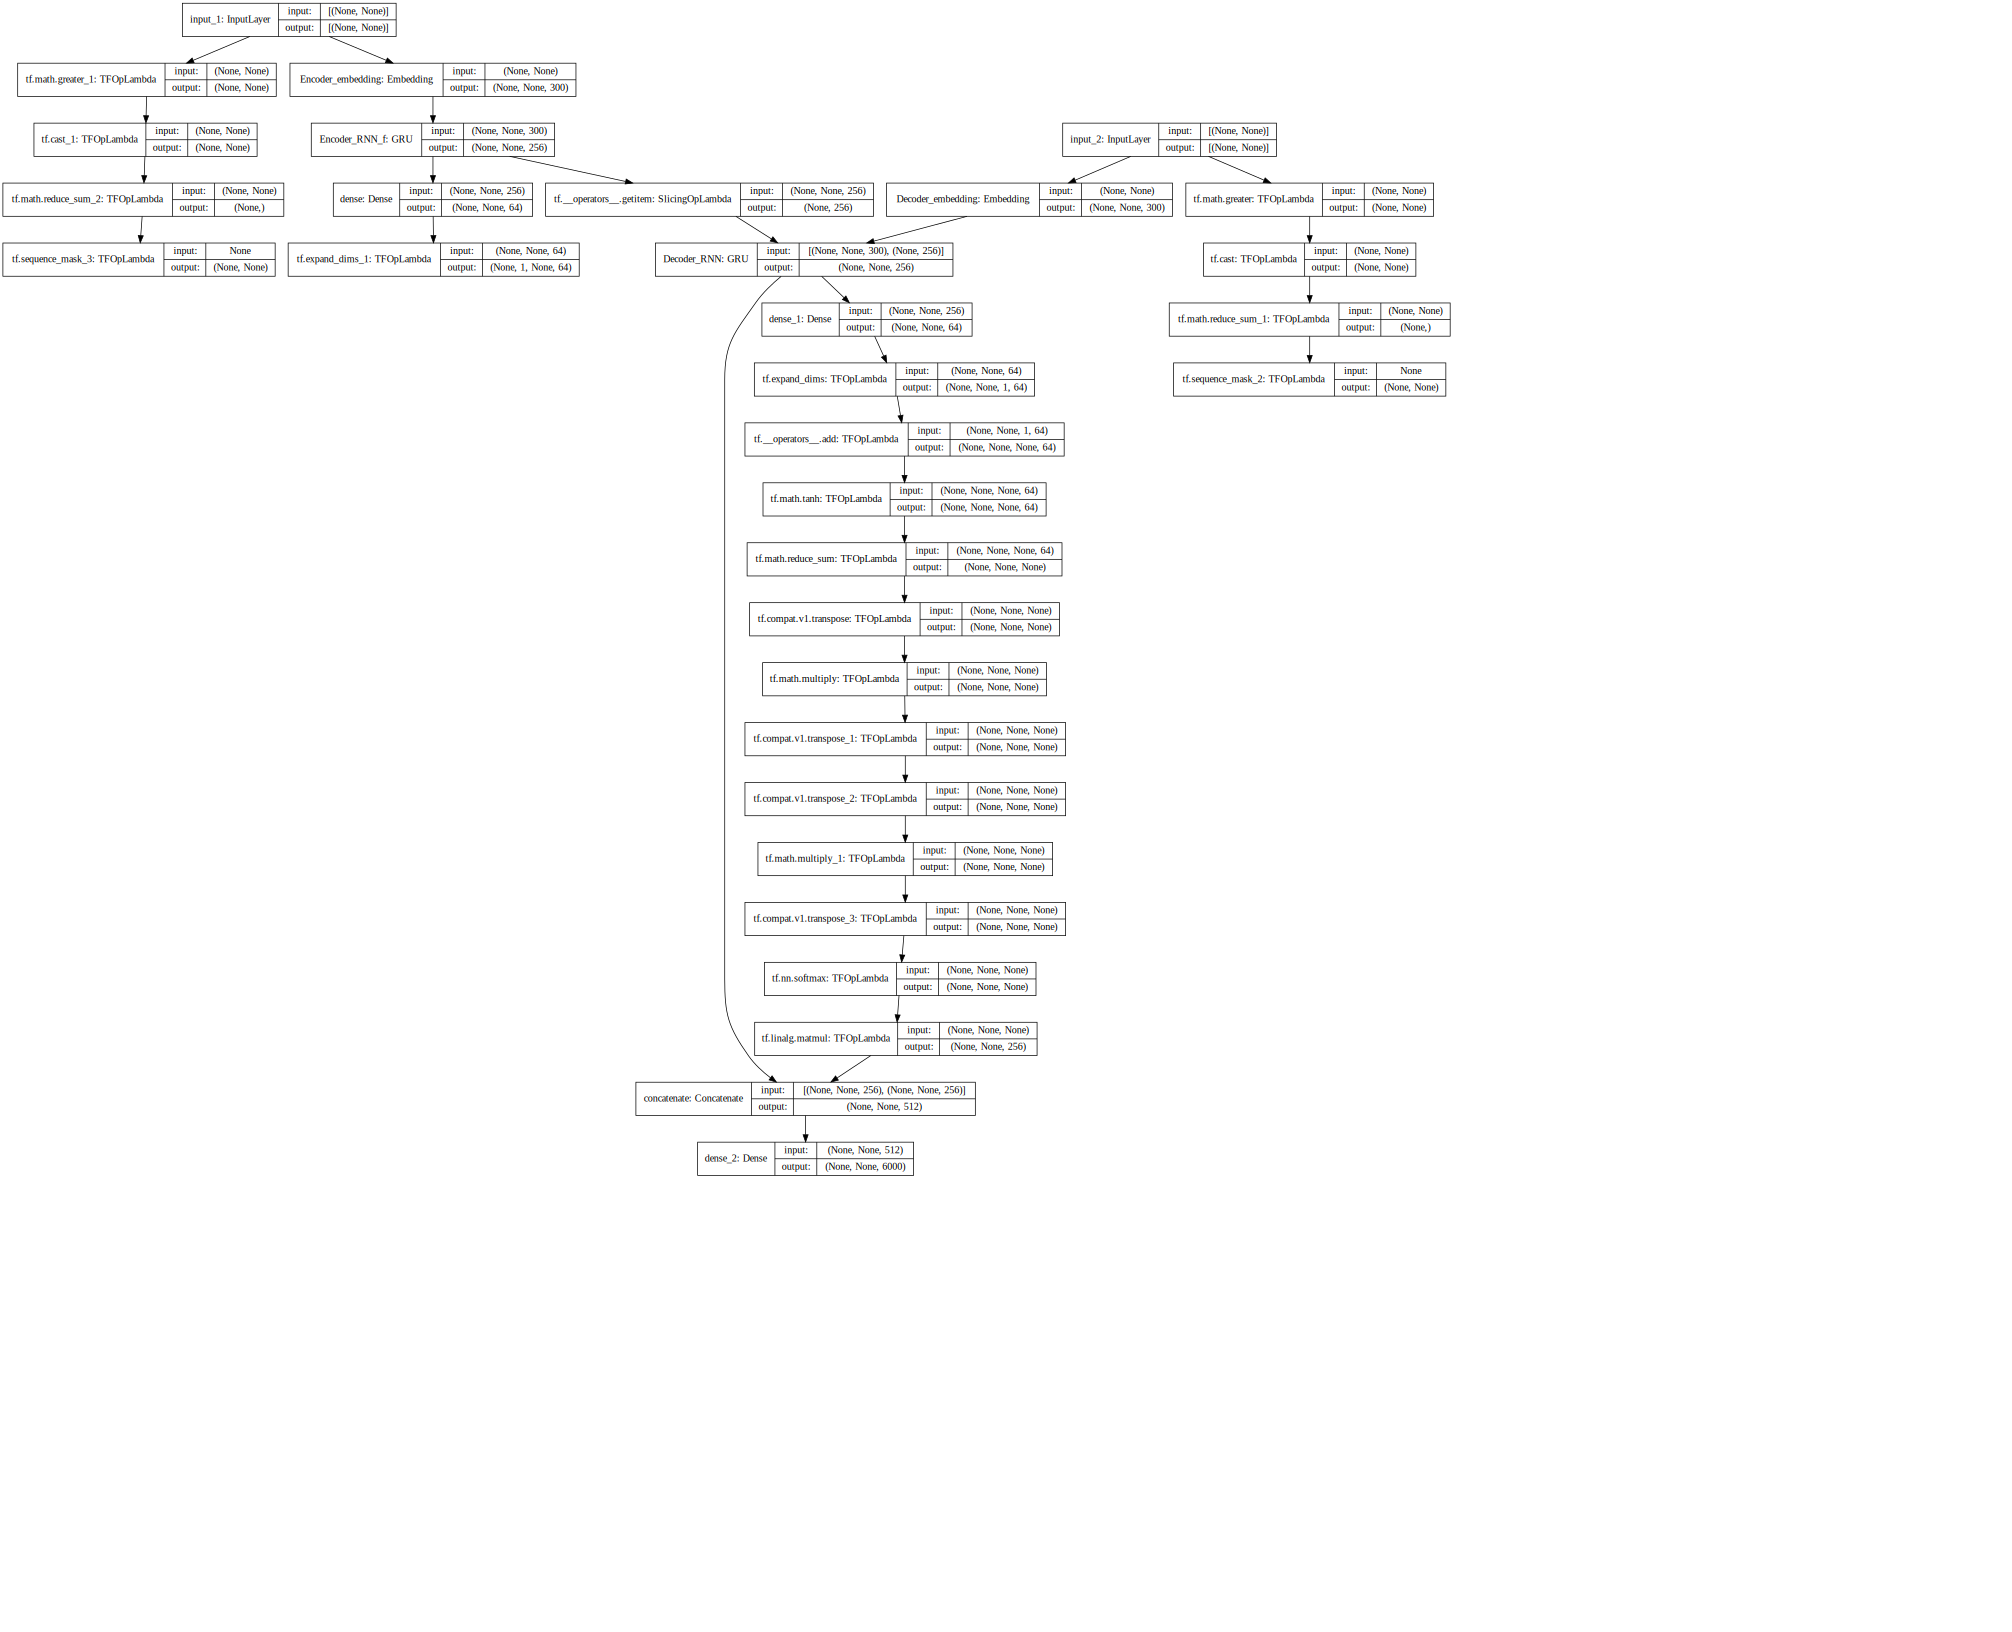

In [ ]:
#MODEL FLOWCHART
import pydot
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
SVG(model_to_dot(model2,  show_shapes=True, show_layer_names=True, dpi=52, rankdir='TB').create_svg())

In [ ]:
#MODEL TRAINING
#TRAINED FOR 40 EPOCHS IN ROUNDS OF 20 EACH AFTER WHICH THE WEIGHTS WERE SAVED
history2=model2.fit(dataset,epochs=20,verbose=1)

Epoch 1/20
340/340 [==============================] - 22s 65ms/step - loss: 0.4404
Epoch 2/20
340/340 [==============================] - 22s 65ms/step - loss: 0.4347
Epoch 3/20
340/340 [==============================] - 23s 66ms/step - loss: 0.4291
Epoch 4/20
340/340 [==============================] - 23s 67ms/step - loss: 0.4246
Epoch 5/20
340/340 [==============================] - 23s 67ms/step - loss: 0.4216
Epoch 6/20
340/340 [==============================] - 23s 67ms/step - loss: 0.4171
Epoch 7/20
340/340 [==============================] - 23s 67ms/step - loss: 0.4128
Epoch 8/20
340/340 [==============================] - 23s 67ms/step - loss: 0.4093
Epoch 9/20
340/340 [==============================] - 23s 68ms/step - loss: 0.4069
Epoch 10/20
340/340 [==============================] - 23s 67ms/step - loss: 0.4035
Epoch 11/20
340/340 [==============================] - 23s 68ms/step - loss: 0.4010
Epoch 12/20
340/340 [==============================] - 23s 69ms/step - loss: 0.4024
E

In [ ]:
#SAVING THE MODEL
model2.save('/content/drive/MyDrive/Colab Notebooks/UNIV-AI-AI3/encode.h5')
del model2

In [ ]:
##LOADING THE SAVED MODEL
from keras.models import load_model
model2=load_model('/content/drive/MyDrive/Colab Notebooks/UNIV-AI-AI3/encode.h5')

5.1 INFERENCE FROM THE SEQ2SEQ MODEL<br>

In inference mode, i.e. when we want to obtain the result on an unknown input sequences, we go through a slightly different process:

1. Encode the input sequence into state vectors.
2. Start with a target sequence of size 1 (just the start-of-sequence character).
3. Feed the state vectors and 1-char target sequence to the decoder to produce predictions for the next character.
4. Sample the next character using these predictions (we simply use argmax).
5. Append the sampled character to the target sequence
6. Repeat until we generate the end-of-sequence character or we hit the character limit.

In [ ]:
# INFERENCE LOOP
#FOR SEQ2SEQ MODELS, THE INFERENCE IS DONE BY PASSING THE ENCODER INPUT AND
#A START TOKEN AS THE DECODER INPUT. THE OUTPUT OF THE DECODER IS THEN AGAIN
#PASSED TO THE DECODER INPUT IN A LOOP UNTIL THE COMPLETE OUTPUT IS GENERATED
def evaluate(test_ques):
  print('The question is:',test_ques)
  sentence = texts_to_sequences(encode_data(test_ques))
  START_TOKEN=[word2idx['<s>']]
  END_TOKEN=[word2idx['</s>']]
  sentence = tf.expand_dims(
      START_TOKEN + sentence + END_TOKEN, axis=0)
  output = tf.expand_dims(START_TOKEN, 0)
  for i in range(20):
    predictions = model2(inputs=[sentence, output], training=False)
    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

def predict(sentence):
  prediction = evaluate(sentence)
  predicted_sentence = sp.decode_pieces([idx2word[i] for i in prediction.numpy()])
  return predicted_sentence

In [ ]:
for i in np.random.randint(0,18000,5):
  print(i)
  print('\033[1m'+'The predicted answer is:'+'\033[0m',predict(df.question.iloc[i]))
  print('\033[1m'+'The actual answer is:'+'\033[0m',df.text.iloc[i])

5650
Which contestant reportedly received a death threat on the show?
The predicted answer is: automatic mps
The actual answer is: John Stevens
17587
What nation does the Marshall Islands vote similarly to in the General Assembly?
The predicted answer is: the north african states
The actual answer is: the United States
4
In which decade did Beyonce become famous?
The predicted answer is: the early 1970s
The actual answer is: late 1990s
4199
The placement of deciduous trees on the Equator facing side of a building can have a negative effect on solar availability in which season?
The predicted answer is: spring
The actual answer is: winter
10616
In what year did Bell get some of Edison's patents?
The predicted answer is: 2013
The actual answer is: 1879


These are some of the output for the SQUAD dataset answers. Now we will test out model on the test dataset provided for the Challenge. **Since we are not doing any fine tuning for the baseline model on the this particular data (faqs data), the model isn't expected to perform that well on this test set**. 

 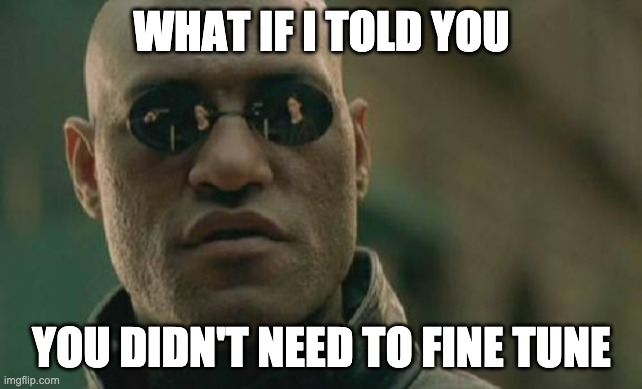

In [ ]:
test_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UNIV-AI-AI3/test.csv')
test_df.head()

,Questions
0,Will the pre-class session be recorded?
1,What is the deadline for quiz submission?
2,What is the deadline for exercise submission?
3,How many hours do I need to complete this course?
4,Who will grade the exercise?


In [ ]:
for i in test_df.Questions.values:
  print('\033[1m'+'The predicted answer is:'+'\033[0m',predict(i))

Will the pre-class session be recorded?
The predicted answer is: mechanical
What is the deadline for quiz submission?
The predicted answer is: digital
What is the deadline for exercise submission?
The predicted answer is: shiva
How many hours do I need to complete this course?
The predicted answer is: time forda
Who will grade the exercise?
The predicted answer is: perfective heart failure
Why is the auto-grader failing me?
The predicted answer is:  ⁇ frow triangle
Do I do the exercises individually?
The predicted answer is: the meaning of the expression of the entire world
Is the lab compulsory?
The predicted answer is: the  ⁇ orfel ⁇  and the orogenna
Will the sessions be recorded?
The predicted answer is: computing
Can I have access to the recorded videos?
The predicted answer is: the crusader
Where are the recordings?
The predicted answer is: salvia ⁇  d ⁇ otia ⁇  and rabilia
Where can I ask questions regarding reading material
The predicted answer is: the lower level of the proces

In hindsight, we should have fine-tuned the model. But since its a baseline, we don't care much. As we can see the model is giving random answers for all of the questions.<br>
We are going to improve on this baseline by building a Transformer model, which is implemented in a separate notebook. Please refer to that notebook for further work.<br>
Thanks for the read.
